# Hospital Readmission Prediction
Using machine learning to build prediction models to classify patients with risk of readmission into three classes (No Readmission, <30 Readmission, >30 Readmission)

# Modules

In [86]:
##############################
# Import Modules
##############################

import itertools
import numpy as np
import pandas
import sklearn
from imblearn.metrics import specificity_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os, csv
import pprint

In [87]:
##############################
# Suppress Warnings Settings and Display Settings
##############################

# suppress warnings completely
warnings.filterwarnings('ignore')

# suppress warnings after seen once
# warnings.filterwarnings(action='once')

# pretty print settings
pp = pprint.PrettyPrinter(indent=4)

# dataframe display settings
pandas.options.display.max_columns = None

# Data Import

In [88]:
##############################
# Import Dataset
##############################

# import dataset from csv
dataframe = pandas.read_csv('dataset/diabetic_data_initial.csv', engine='python')

# curated dataframe
curated_df = pandas.read_csv('dataset-curation/curated_data_v0.csv', engine='python')

# select dataframe to use [dataframe, male_dataframe, female_dataframe]
use_dataframe = curated_df


# Data Preparation

In [89]:
##############################
# Data Preprocessing (Step 1)
#        Shuffle Data Set
#        Remove Irrelevant Columns
#        Convert Categorical Feature to Binary
#        Seperate features from targets
##############################

# shuffle data set
def shuffle(df):
    return df.sample(frac=1).reset_index(drop=True)

# drop columns with specified label
def dropColumn(df, colLabels):
    for colLabel in colLabels:
        if colLabel in df.columns:
            df.drop([colLabel], axis=1, inplace=True)
    return df

# convert feature from categorical to binary
def categoricalToBinary(df, colLabel):
    if colLabel in df.columns:
        df = pandas.get_dummies(df, columns=[colLabel])
    return df

# return features (X) and target (Y) from dataframe
def seperateDataTargets(df, targetLabel):
    X = df.drop(targetLabel, axis=1).values
    Y = df[targetLabel].values.ravel()
    return X, Y

# convert to binary classes: 1 (positive) or 0 (negative)
def convertToBinaryClass(y):
    for i in range(len(y)):
        if y[i] != 1:
            y[i] = 0
        else:
            y[i] = 1
    return np.array(y)

target_name = 'readmitted'
use_dataframe = shuffle(use_dataframe)
use_dataframe = dropColumn(use_dataframe, ['encounter_id', 'patient_nbr', 'weight', 'citoglipton', 'examide', 'glimepiride-pioglitazone'])


In [90]:
# display some statistics of data set
# use_dataframe.describe()

In [91]:
# display the unique feature values
use_dataframe.nunique()

race                          6
gender                        3
age                          10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
payer_code                   18
medical_specialty            71
num_lab_procedures          116
num_procedures                7
num_medications              75
number_outpatient            33
number_emergency             18
number_inpatient             13
diag_1                      697
diag_2                      726
diag_3                      759
number_diagnoses             16
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 2
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglit

In [92]:
##############################
# Data Preprocessing (Step 2)
#        Set Types for Columns
#        Find and Replace Terms
#        Impute values for NaN
##############################

# find and replace Unknown
use_dataframe.replace('?',np.NaN,inplace=True)

# print rows that have at least 1 missing value
# use_dataframe[use_dataframe.isnull().any(axis=1)]


In [93]:
# display percentage missing data per feature
use_dataframe.isna().sum().sort_values(ascending=False)

medical_specialty           34477
payer_code                  31043
race                         1948
diag_3                       1225
diag_2                        294
diag_1                         11
num_medications                 0
max_glu_serum                   0
number_diagnoses                0
number_inpatient                0
number_emergency                0
number_outpatient               0
num_procedures                  0
diabetesMed                     0
num_lab_procedures              0
time_in_hospital                0
admission_source_id             0
discharge_disposition_id        0
admission_type_id               0
age                             0
gender                          0
A1Cresult                       0
readmitted                      0
repaglinide                     0
miglitol                        0
change                          0
metformin-pioglitazone          0
metformin-rosiglitazone         0
glipizide-metformin             0
glyburide-metf

In [94]:
##############################
# Data Preprocessing (Step 3)
#        Change type to Category
#        Label Encoding
#        One-Hot Encoding
##############################

# change object type to category type
obj_to_category_list = use_dataframe.select_dtypes(include=['object']).columns.tolist()

for obj in obj_to_category_list:
    use_dataframe[obj] = use_dataframe[obj].astype('category')


# save label encodings to le_dict
le_dict = {}
cols_for_le = obj_to_category_list

for col in cols_for_le:
    le_dict[col] = dict(enumerate(use_dataframe[col].cat.categories))


# label encoding
for col in cols_for_le:
    use_dataframe[col] = use_dataframe[col].cat.codes


# one hot encoding
# cols_for_he = ['medical_specialty'] # can try: 'diag_1', 'diag_2', 'diag_3'
# use_dataframe = pandas.get_dummies(use_dataframe, columns=cols_for_he, dummy_na=True)


# convert boolean classes to int (0 - False, 1 - True)
# use_dataframe['Diabetic'] = use_dataframe['Diabetic'].astype(int)
# use_dataframe['Hypertension'] = use_dataframe['Hypertension'].astype(int)


# seperate X, Y and binarize outcome Y
X, Y = seperateDataTargets(use_dataframe, [target_name])

In [95]:
# label encoding dictionary
skiplabels = ['diag_1', 'diag_2', 'diag_3']
keys = list(le_dict.keys())
pp.pprint([{k: le_dict[k]} for k in keys if k not in skiplabels])

[   {   'race': {   0: 'AfricanAmerican',
                    1: 'Asian',
                    2: 'Caucasian',
                    3: 'Hispanic',
                    4: 'Other'}},
    {'gender': {0: 'Female', 1: 'Male', 2: 'Unknown/Invalid'}},
    {   'age': {   0: '[0-10)',
                   1: '[10-20)',
                   2: '[20-30)',
                   3: '[30-40)',
                   4: '[40-50)',
                   5: '[50-60)',
                   6: '[60-70)',
                   7: '[70-80)',
                   8: '[80-90)',
                   9: '[90-100)'}},
    {   'payer_code': {   0: 'BC',
                          1: 'CH',
                          2: 'CM',
                          3: 'CP',
                          4: 'DM',
                          5: 'FR',
                          6: 'HM',
                          7: 'MC',
                          8: 'MD',
                          9: 'MP',
                          10: 'OG',
                          11: 'OT',
   

# Data Characteristics

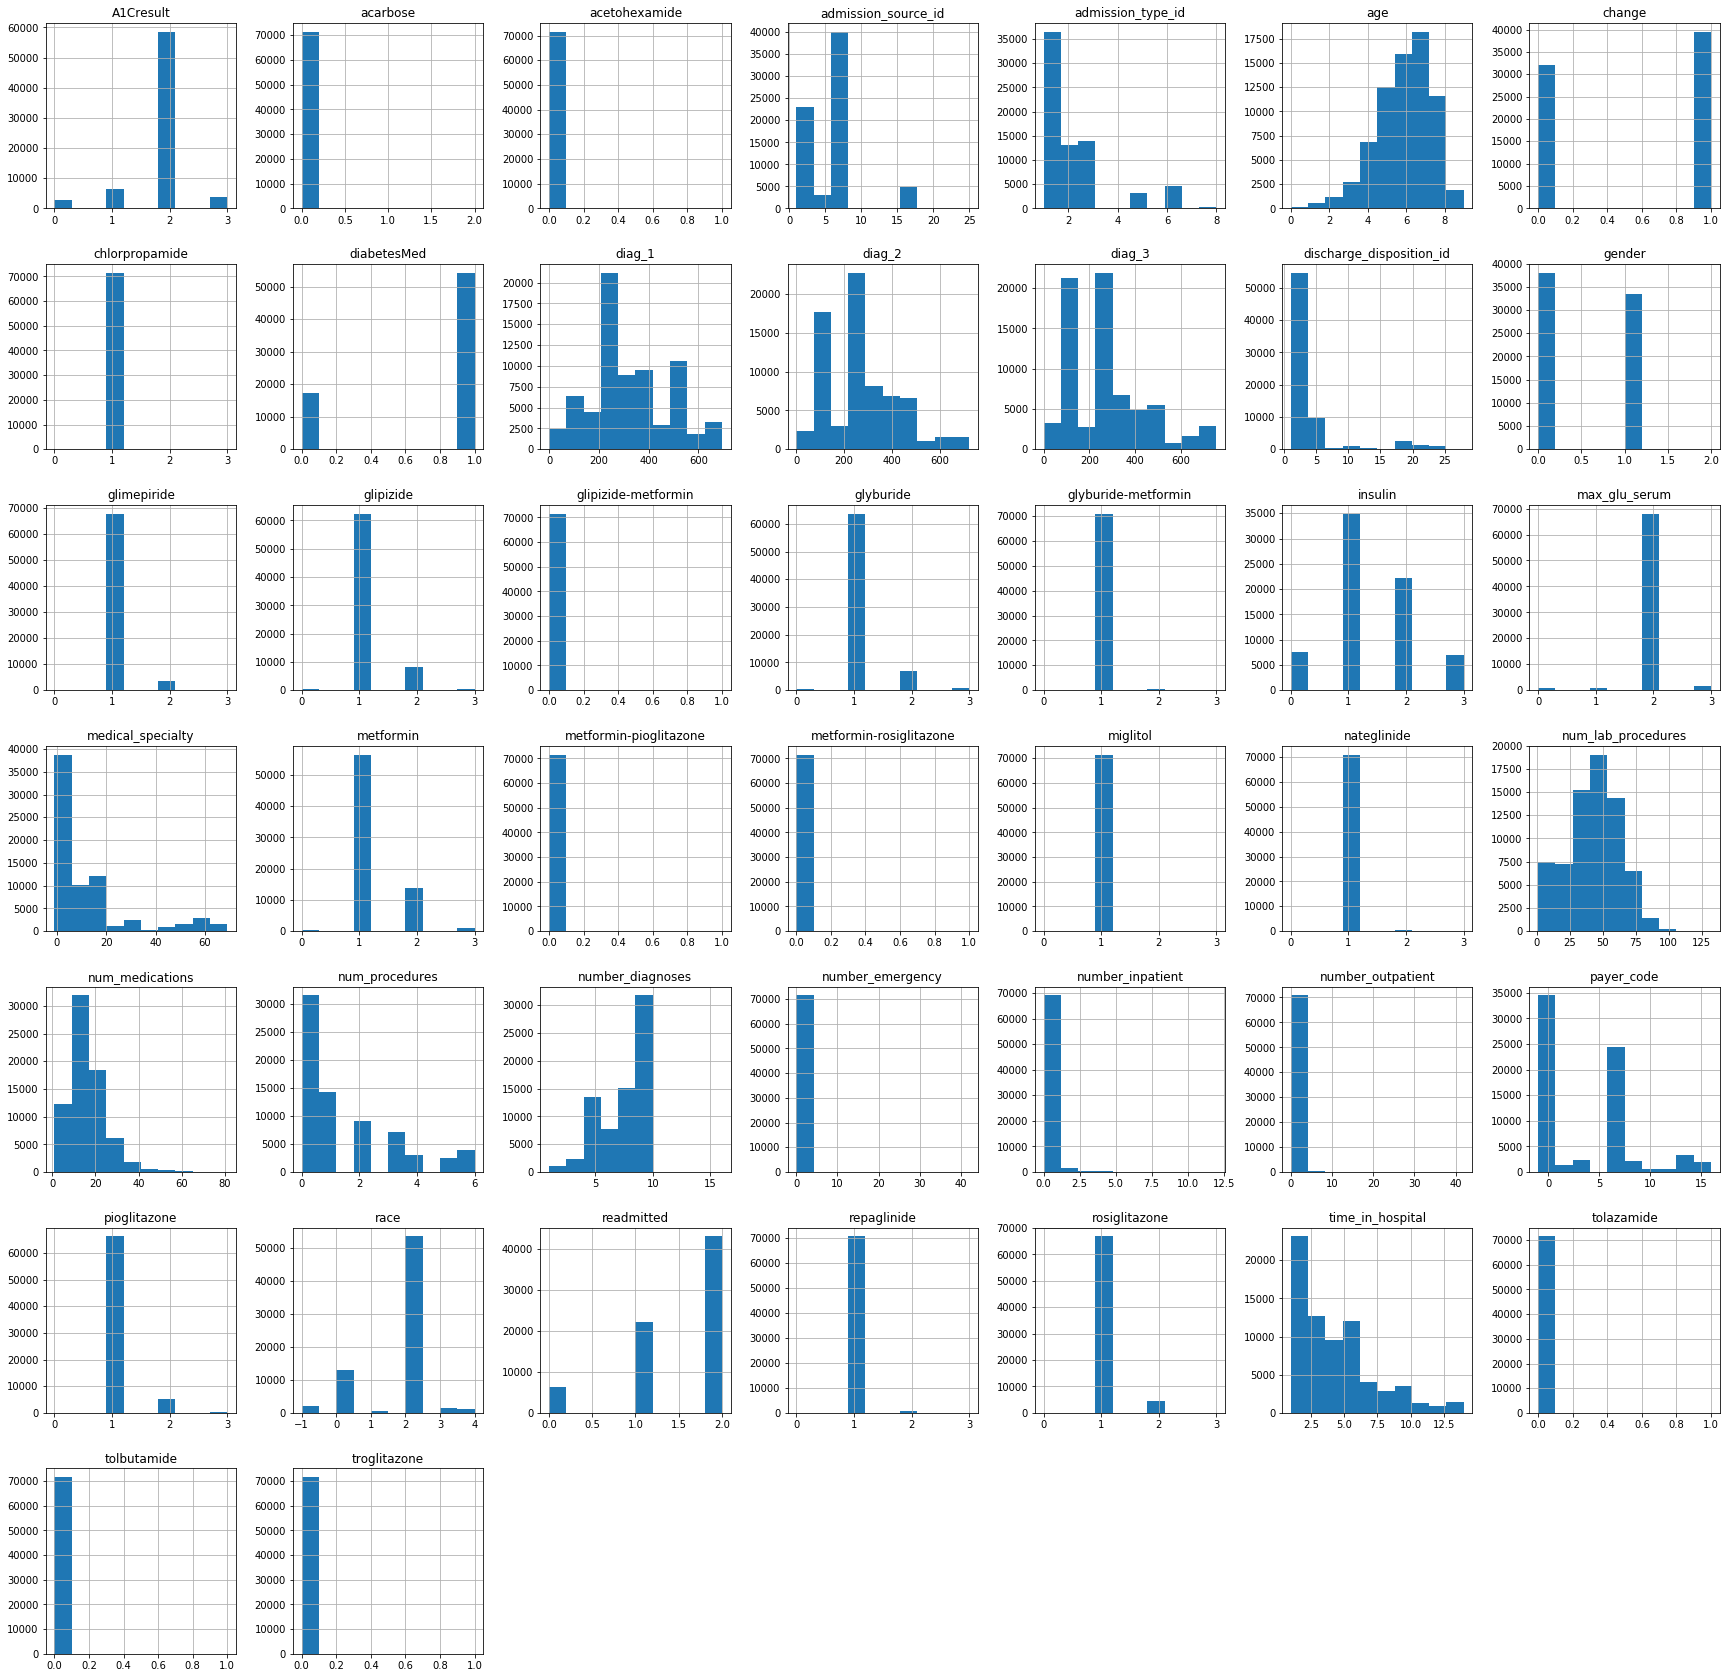

In [96]:
fig = plt.figure(figsize = (30, 30))
ax = fig.gca()
use_dataframe.hist(ax = ax)
plt.show()

In [97]:
# display top rows of data set after preprocessing
use_dataframe.head(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2,1,5,2,1,1,3,6,60,38,2,10,0,0,0,385,77,370,5,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,2,1,0,0,0,1,1,2
1,2,0,8,6,1,1,9,-1,18,40,2,8,0,0,1,688,96,141,5,0,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,3,1,0,0,0,0,1,1
2,2,1,7,1,1,7,4,-1,-1,48,3,15,0,0,0,253,240,236,7,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,0,0,0,1,1,1
3,2,0,6,3,1,1,2,7,18,37,0,21,0,0,0,149,375,130,9,2,2,1,1,1,1,1,0,1,1,0,2,1,0,1,0,0,2,1,0,0,0,0,1,2
4,2,1,4,2,1,7,2,2,8,62,3,21,0,1,0,386,367,142,7,2,1,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,3,1,0,0,0,0,1,2
5,2,0,7,2,1,1,1,-1,18,20,0,8,0,0,0,269,76,236,9,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1
6,2,0,5,1,1,7,4,7,11,51,0,21,0,3,1,316,702,308,9,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,2,1,0,0,0,1,1,0
7,2,0,7,2,3,7,13,7,8,49,0,10,0,0,0,269,251,144,9,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,2
8,2,1,5,1,1,7,3,0,8,42,0,18,0,0,0,250,376,91,6,2,2,1,1,1,1,1,0,1,1,0,2,1,0,1,0,0,3,1,0,0,0,0,1,2
9,2,0,7,1,1,7,3,14,-1,42,0,17,0,0,0,531,309,258,8,2,2,1,1,1,1,1,0,2,1,0,1,1,0,1,0,0,1,1,0,0,0,1,1,1


In [98]:
# display statistics of data set (for categorical vars use include='all')
use_dataframe.describe(include='all')

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,1.605106,0.468358,6.065186,2.100254,3.593235,5.657457,4.28913,3.556335,10.927641,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,328.530971,264.362189,260.826114,7.245700,1.986535,1.884015,1.209164,1.013158,1.006963,1.001035,1.051791,0.000014,1.124836,1.106728,0.000266,1.074471,1.065536,0.002964,1.000266,0.000042,0.000419,1.399200,1.007005,0.000098,0.000028,0.000014,0.552225,0.759515,1.513046
std,0.950804,0.499085,1.597808,1.508301,5.269771,4.162580,2.94921,4.874734,17.317972,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,154.895917,151.326330,173.896729,1.994674,0.297977,0.537958,0.448349,0.125845,0.087098,0.034256,0.244009,0.003739,0.368766,0.352815,0.016297,0.276088,0.259119,0.056879,0.017931,0.006477,0.020477,0.802774,0.085228,0.009893,0.005288,0.003739,0.497269,0.427381,0.652548
min,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,-1.000000,-1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,1.000000,1.000000,1.000000,2.00000,-1.000000,-1.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,253.000000,132.000000,129.000000,6.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2.000000,0.000000,6.000000,1.000000,1.000000,7.000000,3.00000,2.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,288.000000,249.000000,238.000000,8.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
75%,2.000000,1.000000,7.000000,3.000000,3.000000,7.000000,6.00000,7.000000,18.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,444.000000,359.000000,338.000000,9.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
max,4.000000,2.000000,9.000000,8.000000,28.000000,25.000000,14.00000,16.000000,69.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,695.000000,724.000000,757.000000,16.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,1.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.0000

In [99]:
# display dataset feature types
use_dataframe.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 44 columns):
race                        71518 non-null int8
gender                      71518 non-null int8
age                         71518 non-null int8
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
payer_code                  71518 non-null int8
medical_specialty           71518 non-null int8
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
diag_1                      71518 non-null int16
diag_2                      71518 non-null int16
diag_3                      71518 non-null int16
number_diagnos

In [100]:
##############################
# Data Set Characteristics
#        Store Data Set Characteristics
##############################

# feature names and class names
feature_names = use_dataframe.drop([target_name, 'encounter_id', 'patient_nbr'], axis=1, errors='ignore').columns.tolist()
class_names = ['>30', '<30', 'NO'] # >30 readmission, <30 days readmission, No readmission

# number of rows and columns
num_cols = use_dataframe.shape[1]
num_rows = use_dataframe.shape[0]

# print basic data set characteristics
# print('\n'.join(feature_names))
# print("\nNumber of Rows: " + str(num_rows))
# print("Number of Cols: " + str(num_cols))

# Define Classifiers & Transformations

In [30]:
##############################
# Classifiers and Parameters:
#        Dictionary of Classifiers & Parameters for Grid Search
##############################

classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'kNN': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Gaussian Process': GaussianProcessClassifier(n_jobs=-1),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Ada Boost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier()
}

clf_params = {
    'Decision Tree': 
        {
            'clf__criterion': ["gini", "entropy"],
            'clf__class_weight': [None, "balanced", {0:10, 1:20, 2:1}, {0:20, 1:40, 2:1}],
            'clf__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 40, 50, None],
            'clf__max_features': [None, "auto", "log2"],
            'clf__max_leaf_nodes': [20, 30, 40, 50, 60, None],
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.001, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 1]            
        },
    'kNN': 
        {
            'clf__n_neighbors': np.arange(1, 30),
            'clf__p': np.arange(1, 6)
        },
    'Gaussian Naive Bayes': {}, # no hyperparameters
    'Bernoulli Naive Bayes': {}, # requires: binarize all features
    'Gaussian Process': 
        {
            'clf__kernel': [None, Matern()],
            'clf__optimizer': ["fmin_l_bfgs_b"],
            'clf__n_restarts_optimizer': np.arange(0, 10)
        },
    'SVM': 
        {
            'clf__kernel': ["linear", "poly", "rbf", "sigmoid"],
            'clf__C': [0.1, 1, 10, 100],
            'clf__gamma': [0.1, 1, 10, 100],
            'clf__degree': np.arange(0, 7),
#             'clf__class_weight': ["balanced", {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:40}, {0:1, 1:80}, {0:1, 1:160}]
        },
    'Random Forest': 
        {
            'clf__n_estimators': [1, 8, 12, 16, 18, 20, 22, 24, 26],
            'clf__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 40, 50, None],
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.001, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 1],
            'clf__max_features': ["auto", "log2", None],
            'clf__class_weight': [None, "balanced", {0:10, 1:20, 2:1}, {0:20, 1:40, 2:1}]
        },
    'Ada Boost': 
        {
            'clf__base_estimator': [DecisionTreeClassifier(criterion="gini",
                                                           max_depth=None,
                                                           min_samples_split=0.1,
                                                           min_samples_leaf=1,
                                                           max_features=None,
                                                           max_leaf_nodes=20,
                                                           class_weight=None)], # need to find best dt models and input them here
            'clf__n_estimators': [1, 2, 3, 8, 16, 32, 64, 100, 200],
            'clf__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'clf__class_weight': [None, "balanced", {0:10, 1:20, 2:1}, {0:20, 1:40, 2:1}],
        },
    'Gradient Boosting': 
        {
            'clf__learning_rate': [1, 0.5],
            'clf__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100],
            'clf__max_depth': np.append(range(1,20), None),
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 1],
            'clf__max_features': ["auto", "log2", None]
        },
    'MLP': 
        {
            'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'clf__activation': ['logistic', 'tanh', 'relu'],
            'clf__solver': ['lbfgs', 'sgd', 'adam'],
            'clf__alpha': [0.0001, 0.001, 0.05, 0.01],
            'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
        }
}

feature_select_params = {
    'feature_select__score_func': [f_classif],
    'feature_select__k': [5, 10, 15, 20, 'all']
}

feature_transform_params = {}

In [31]:
##############################
# Build Pipeline
# 
# 1. Feature Selection
# 2. Feature Transformation
# 3. Classifiers
##############################

pipelines = {}

# 1. Feature Selection
feature_select = SelectKBest()

# 2. Feature Transformation
feature_scale = StandardScaler(copy=True, with_mean=True, with_std=True)
feature_transform = PCA() # classifiers perform worse with linear PCA

for key, clf in classifiers.items():
    pipelines[key] = Pipeline([
        ('feature_select', feature_select),
        ('feature_scale', feature_scale),
#         ('feature_transform', feature_transform),
        ('clf', clf)
    ])

In [32]:
# pipeline test code
# pipelines['Decision Tree'].get_params()

In [33]:
##############################
# Confusion Matrix Plot Function
##############################

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     print(cm)
#     print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [34]:
##############################
# Set Scoring Metrics
#        Custom Scorer: Specificity
##############################

from mymetrics import specificity_scorer

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_macro', 
           'precision': 'precision_macro',
           'recall': 'recall_macro',
           'specificity': specificity_scorer
#            'auc': 'roc_auc',
          }

primary_metric = 'accuracy'

# Hyperparameter Tuning

In [46]:
%%time
##############################
# Random Search
##############################

# make random search object with pipeline and param grid
def makeRandomSearchObj(pipeline, params):
    random_search = RandomizedSearchCV(pipeline, 
                               params,
                               n_iter=1000, 
                               cv=KFold(10), 
                               scoring=scoring,
                               refit=primary_metric,
                               return_train_score=False,
                               n_jobs=20)
    return random_search


# execute random search
clf_name = 'Gradient Boosting'
params = {**clf_params[clf_name], **feature_select_params, **feature_transform_params}
random_search = makeRandomSearchObj(pipelines[clf_name], 
                                params)
random_search.fit(X, Y)
search_results = random_search

Wall time: 24.3 s


# Cross Validation Results

In [19]:
##############################
# Write Results to CSV File
##############################
FOLDER = 'results'

PRINT_COLUMNS = {
    'mean_test_f1': 'f1',
    'std_test_f1': 'f1_std',
    'rank_test_f1': 'f1_rank',
    'mean_test_recall': 'recall',
    'std_test_recall': 'recall_std',
    'rank_test_recall': 'recall_rank',
    'mean_test_precision': 'precision',
    'std_test_precision': 'precision_std',
    'rank_test_precision': 'precision_rank',
    'mean_test_auc': 'auc',
    'std_test_auc': 'auc_std',
    'rank_test_auc': 'auc_rank',
    'mean_test_accuracy': 'acc',
    'std_test_accuracy': 'acc_std',
    'rank_test_accuracy': 'acc_rank',
    'mean_test_specificity': 'spec',
    'std_test_specificity': 'spec_std',
    'rank_test_specificity': 'spec_rank'}

PRINT_COLUMNS_KEYS = list(PRINT_COLUMNS.keys())

# createt list of rows from cv_results dict
def dictToList(in_dict):
    header = []
    resultList = []
    
    # iterate over items in dict
    for k, v in in_dict.items():
        if k in PRINT_COLUMNS_KEYS or "param_" in k:
            header_name = PRINT_COLUMNS[k] if k in PRINT_COLUMNS_KEYS else k
            header.append(header_name)
            resultList.append(v)
    
    return header, np.array(resultList)


# write list of rows to csv file
def writeRowsToCsv(file_name, listOfRows, header=None):
    
    # check if directory exists
    if not os.path.isdir(FOLDER):
        os.makedirs(FOLDER)
    
    # check if file exists (overwrite if it does)
    file_location = os.path.join(FOLDER, file_name)
    if os.path.isfile(file_location):
        os.remove(file_location)
    
    # write results to csv file
    with open(file_location, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        if header is not None:
            writer.writerow(header)
        writer.writerows(listOfRows)
        
    print('\nResults saved to: ' + file_location)
    

# call functions to write results to csv
file_name = 'results_{}.csv'.format(
    datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
header, resultList = dictToList(search_results.cv_results_)
writeRowsToCsv(file_name, np.transpose(resultList).tolist(), header)
    


Results saved to: results/results_2019-03-10-00-13-42.csv


In [47]:
##############################
# Display Summary of Grid Search
##############################

result = search_results.cv_results_
best_index = search_results.best_index_

print("BEST PARAMS ({}):".format(primary_metric))
pp.pprint(search_results.best_params_)

print("\nBEST MODEL RESULTS ({}):".format(primary_metric))
for metric in scoring:
    print("{0:16} {1:.3f} (+/-{2:.3f})".format(
        metric,
        result['mean_test_{}'.format(metric)][best_index], 
        result['std_test_{}'.format(metric)][best_index]))

print("\nACROSS ALL MODELS:")
for metric in scoring:
    test_scores = result['mean_test_{}'.format(metric)]
    print(metric)
    print("\tmean\t {0:.3f} (+/-{1:.3f})".format(np.mean(test_scores), np.std(test_scores, ddof=1)))
    print("\tmin\t {:.3f}".format(np.min(test_scores)))
    print("\tmax\t {:.3f}".format(np.max(test_scores)))

BEST PARAMS (accuracy):
{   'clf__class_weight': None,
    'clf__criterion': 'entropy',
    'clf__max_depth': 25,
    'clf__max_features': 'auto',
    'clf__max_leaf_nodes': 30,
    'clf__min_samples_leaf': 0.01,
    'clf__min_samples_split': 0.30000000000000004,
    'feature_select__k': 15,
    'feature_select__score_func': <function f_classif at 0x0000020FAECB4AE8>}

BEST MODEL RESULTS (accuracy):
accuracy         0.554 (+/-0.010)
f1               0.343 (+/-0.043)
precision        0.335 (+/-0.053)
recall           0.380 (+/-0.020)
specificity      0.706 (+/-0.017)

ACROSS ALL MODELS:
accuracy
	mean	 0.426 (+/-0.093)
	min	 0.349
	max	 0.554
f1
	mean	 0.255 (+/-0.088)
	min	 0.173
	max	 0.369
precision
	mean	 0.227 (+/-0.120)
	min	 0.116
	max	 0.403
recall
	mean	 0.361 (+/-0.032)
	min	 0.333
	max	 0.417
specificity
	mean	 0.686 (+/-0.020)
	min	 0.667
	max	 0.711


In [27]:
##############################
# Write Summary to Text File
##############################
FOLDER = 'results'

def getFullPath(filename):
    # check if directory exists
    if not os.path.isdir(FOLDER):
        os.makedirs(FOLDER)
    
    # check if file exists (overwrite if it does)
    file_location = os.path.join(FOLDER, file_name)
    if os.path.isfile(file_location):
        os.remove(file_location)
        
    return file_location

def writeSummaryToTxt(out):
    result = search_results.cv_results_
    best_index = search_results.best_index_

    out.write("BEST PARAMS ({}):\n".format(primary_metric))
    pprint.pprint(search_results.best_params_, stream=out)

    out.write("\nBEST MODEL RESULTS:\n")
    for metric in scoring.keys():
        out.write("{0:16} {1:.3f} (+/-{2:.3f})\n".format(
            metric,
            result['mean_test_{}'.format(metric)][best_index], 
            result['std_test_{}'.format(metric)][best_index]))

    out.write("\nACROSS ALL MODELS:\n")
    for metric in scoring.keys():
        test_scores = result['mean_test_{}'.format(metric)]
        out.write(metric + '\n')
        out.write("\tmean\t {0:.3f} (+/-{1:.3f})\n".format(np.mean(test_scores), np.std(test_scores, ddof=1)))
        out.write("\tmin \t {:.3f}\n".format(np.min(test_scores)))
        out.write("\tmax \t {:.3f}\n".format(np.max(test_scores)))

    
# call functions to write summary to text file
file_name = 'summary_{}.txt'.format(
    datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
path = getFullPath(file_name)

with open(path, 'wt') as out:
    writeSummaryToTxt(out)


In [55]:
##############################
# Classifier Refit on Best Model
##############################
best_clf = search_results.best_estimator_
cv_results = cross_validate(best_clf, X, Y, 
                            cv=KFold(10), 
                            return_train_score=False,
                            scoring=['recall_macro'])

for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


test_recall_macro      0.335 (+/-0.001)


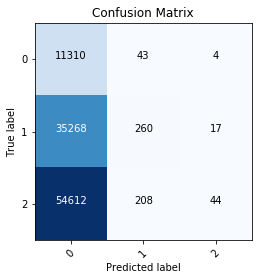

In [60]:
##############################
# Confusion Matrix of the Best Model
##############################
    
y_pred = cross_val_predict(best_clf, X, Y, cv=KFold(10))
conf_mat = confusion_matrix(Y, y_pred)
fig, ax = plt.subplots()
plot_confusion_matrix(conf_mat, classes=np.unique(Y), ax=ax, title='Confusion Matrix')

# Classifier Experiments

In [82]:
# tuned classifiers for testing

clf = DecisionTreeClassifier(criterion="entropy",
                             max_depth=10,
                             min_samples_split=0.1,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_leaf_nodes=35,
                             class_weight={0:1, 1:10})

clfs = {
    'Decision Tree': DecisionTreeClassifier(criterion="entropy",
                             max_depth=10,
                             min_samples_split=0.1,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_leaf_nodes=35),
    'kNN': KNeighborsClassifier(n_neighbors=1, p=5),
    'Gaussian Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(criterion="entropy",
                             max_depth=7,
                             min_samples_split=0.1,
                             min_samples_leaf=0.2,
                             max_features='auto',
                             n_estimators=8),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.5,
                             max_depth=20,
                             min_samples_split=0.4,
                             min_samples_leaf=0.03,
                             max_features='log2',
                             n_estimators=8),
    
    'SVM': SVC(C=0.1,
             degree=1,
             gamma=0.1,
             kernel='poly',
             probability=False)
}

In [83]:
##############################
# Pipeline Fit and Results
##############################

# 1. Feature Selection
feature_select = SelectKBest(k=15, score_func=f_classif)

# 2. Feature Transformation
feature_scale = StandardScaler(copy=True, with_mean=True, with_std=True)
feature_transform = PCA()

# 3. Select classifier
clf = clfs['Gradient Boosting']

exp_pipeline = Pipeline([
        ('feature_select', feature_select),
        ('feature_scale', feature_scale),
#         ('feature_transform', feature_transform),
        ('clf', clf)
])

cv_results = cross_validate(exp_pipeline, X, Y,
                            cv=StratifiedKFold(10), 
                            return_train_score=False,
                            scoring=scoring)

print("PARAMS:")
pp.pprint(exp_pipeline.get_params())

print("\nMODEL RESULTS:")
for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


PARAMS:
{   'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=20,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.03, min_samples_split=0.4,
              min_weight_fraction_leaf=0.0, n_estimators=8,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
    'clf__criterion': 'friedman_mse',
    'clf__init': None,
    'clf__learning_rate': 0.5,
    'clf__loss': 'deviance',
    'clf__max_depth': 20,
    'clf__max_features': 'log2',
    'clf__max_leaf_nodes': None,
    'clf__min_impurity_decrease': 0.0,
    'clf__min_impurity_split': None,
    'clf__min_samples_leaf': 0.03,
    'clf__min_samples_split': 0.4,
    'clf__min_weight_fraction_leaf': 0.0,
    'clf__n_estimators': 8,


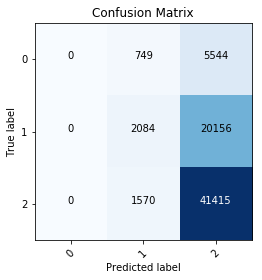

In [37]:
##############################
# Confusion Matrix on Pipeline
##############################
    
y_pred = cross_val_predict(exp_pipeline, X, Y, cv=KFold(10))
conf_mat = confusion_matrix(Y, y_pred)
fig, ax = plt.subplots()
plot_confusion_matrix(conf_mat, classes=np.unique(Y), ax=ax, title='Confusion Matrix')

In [ ]:
##############################
# Single Classifier Fit and Results
##############################

scoring = {'f1': 'f1_macro', 
           'recall': 'recall_macro',
           'precision': 'precision_macro',
#            'auc': 'roc_auc',
           'accuracy': 'accuracy',
#            'specificity': specificity
          }

use_clf = GradientBoostingClassifier()
cv_results = cross_validate(use_clf, X, Y,
                            cv=KFold(10), 
                            return_train_score=False,
                            scoring=scoring)

print("PARAMS:")
pp.pprint(use_clf.get_params())

print("\nMODEL RESULTS:")
for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


# Feature Selection Visualization

In [43]:
##############################
# Feature Selection Example: 
#        ANOVA
#        Mutual Information
##############################

# set base parameters
anova_params = {'score_func': f_classif, 'k': 10}
mi_params = {'score_func': mutual_info_classif, 'k': 10}

# select K best features
feature_select = SelectKBest()


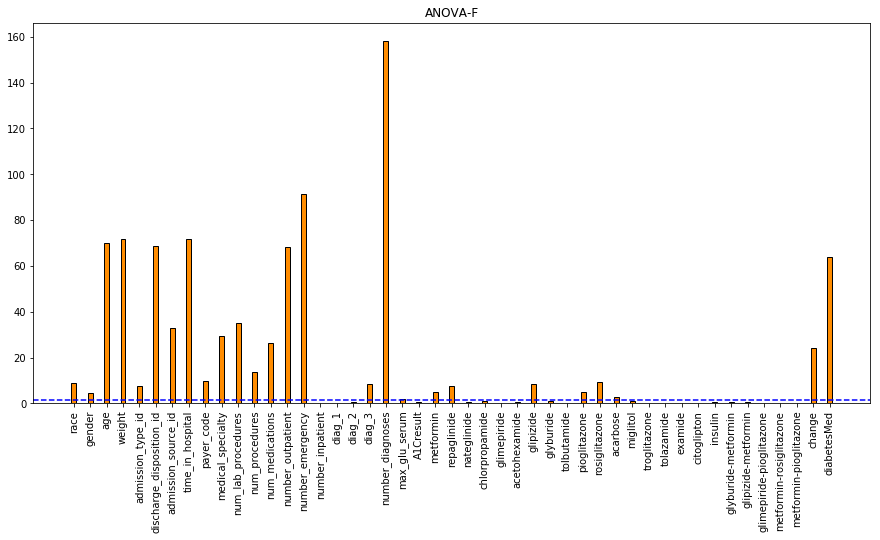

In [44]:
##############################
# Visualize Feature Scores
##############################

# anova feature score calculation
anova_select = feature_select.set_params(**anova_params)
anova_select.fit(X, Y)
scores = -np.log10(anova_select.pvalues_)
# scores /= np.max(scores)


# mi feature score calculation
mi_select = feature_select.set_params(**mi_params)
mi_select.fit(X, Y)
mi = mi_select.scores_
mi /= np.max(mi)


# visualize feature scores - anova
fig, ax = plt.subplots(figsize=(15, 7))
ind = np.arange(len(scores))

plt_anova = plt.bar(ind, scores, width=.3, color='darkorange', edgecolor='black')

ax.set_xticklabels(feature_names)
ax.axhline(-np.log10(0.05), ls='--', color='blue')
plt.xticks(ind, rotation=90)
plt.title('ANOVA-F')
plt.show()


# does not work well with this dataset
# visualize feature scores - mutual information
# fig, ax = plt.subplots(figsize=(15, 7))

# plt_mi = plt.bar(ind, mi, width=.3, color='lightgreen', edgecolor='black')

# ax.set_xticklabels(feature_names)
# plt.xticks(ind, rotation=90)
# plt.title('Mutual Information')
# plt.show()


# Feature Transformation Visualization

In [45]:
##############################
# Feature Transformation Example: 
#        Standard Scalar
#        PCA
#        NMF
#        Kernel PCA
##############################

# transform functions
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
pca = PCA()
nmf = NMF()
kpca = KernelPCA()


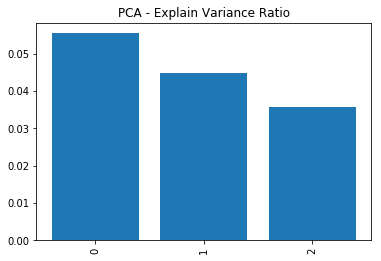

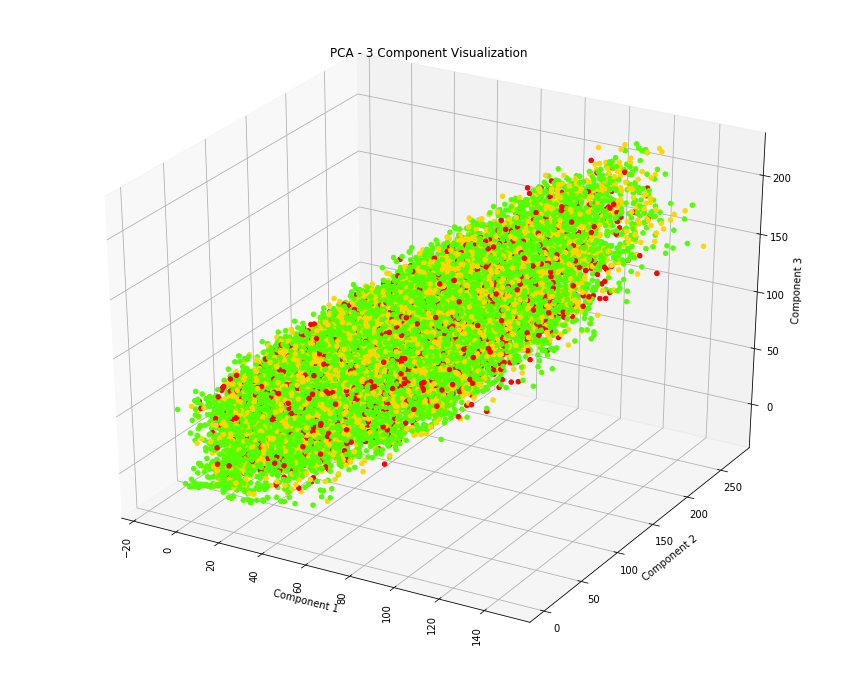

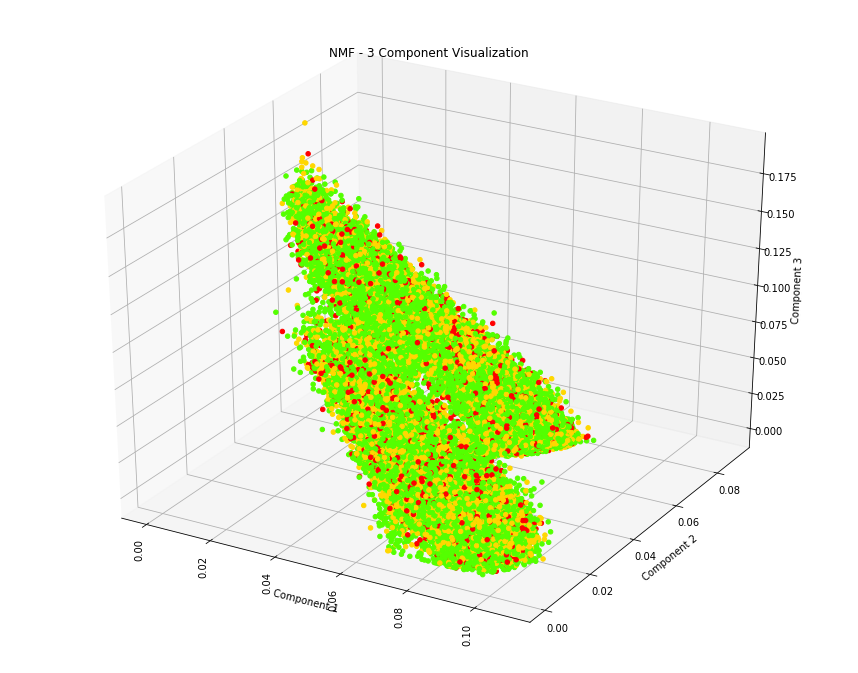

MemoryError: 

In [53]:
##############################
# Visualize Transformed Features
##############################

# set base parameters
pca_params = {'n_components': 3}
nmf_params = {'n_components': 3}
kpca_params = {
               'kernel': "rbf", 
               'gamma': 10,
               'degree': 3 # only for poly kernel
               }

# apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# display explained variance from PCA
pca.set_params(**pca_params)
pca.fit(X_scaled)
ind = np.arange(len(pca.explained_variance_ratio_))

plt.subplots()
plt.bar(ind, pca.explained_variance_ratio_)
plt.xticks(ind, rotation=90)
plt.title("PCA - Explain Variance Ratio")
plt.show()


# display results from PCA
pca_transformed = pca.transform(X)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_transformed[:,0], pca_transformed[:,1], pca_transformed[:,2], c=Y, cmap='prism', alpha=1)
plt.xticks(rotation=90)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("PCA - 3 Component Visualization")
plt.show()


# apply minmax scaler to X
min_max_scaler = MinMaxScaler()
X_minmax_scaled = min_max_scaler.fit_transform(X)

# display results from NMF
nmf.set_params(**nmf_params)
nmf.fit(X_minmax_scaled)
nmf_transformed = nmf.transform(X_minmax_scaled)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(nmf_transformed[:,0], nmf_transformed[:,1], nmf_transformed[:,2], c=Y, cmap='prism', alpha=1)
plt.xticks(rotation=90)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("NMF - 3 Component Visualization")
plt.show()


# display results from KPCA
kpca_params = [{
               'kernel': "poly", 
               'gamma': 10,
               'degree': 3 # only for poly kernel
               },
               {
               'kernel': "poly", 
               'gamma': 10,
               'degree': 8 # only for poly kernel
               },
               {
               'kernel': "rbf", 
               'gamma': 10
               },
               {
               'kernel': "rbf", 
               'gamma': 50
               },
               {
               'kernel': "cosine"
               }]

for kpca_param in kpca_params:
    kpca.set_params(**kpca_param)
    kpca.fit(X_scaled)
    kpca_transformed = kpca.transform(X_scaled)

    plt.subplots(figsize=(15, 12))
    plt.scatter(kpca_transformed[:,0], kpca_transformed[:,1], c=Y, cmap='prism', alpha=1)
    plt.xticks(rotation=90)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("KPCA - Kernel: {}".format(kpca.get_params()['kernel']))
    plt.show()


# Exploratory Data Visualization

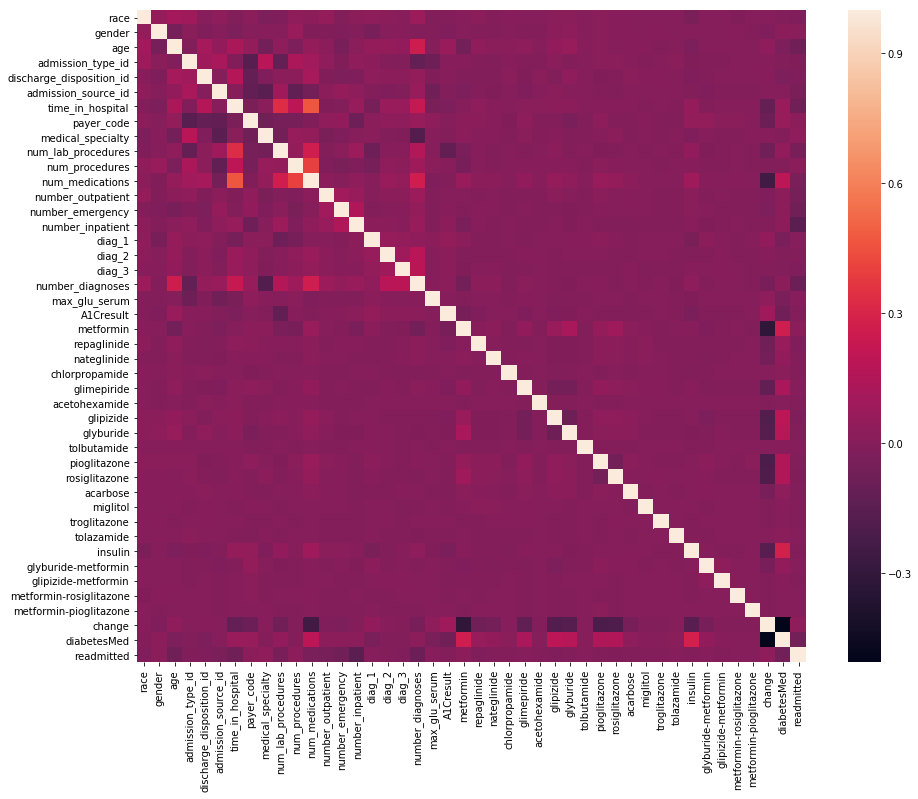

In [102]:
##############################
# Visualize Dataset Characteristics: 
#        Correlation Matrix
##############################

# calculate the correlation matrix
corr = use_dataframe.corr()

# plot the correlation heatmap
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

correlation = corr['readmitted']

# Clustering

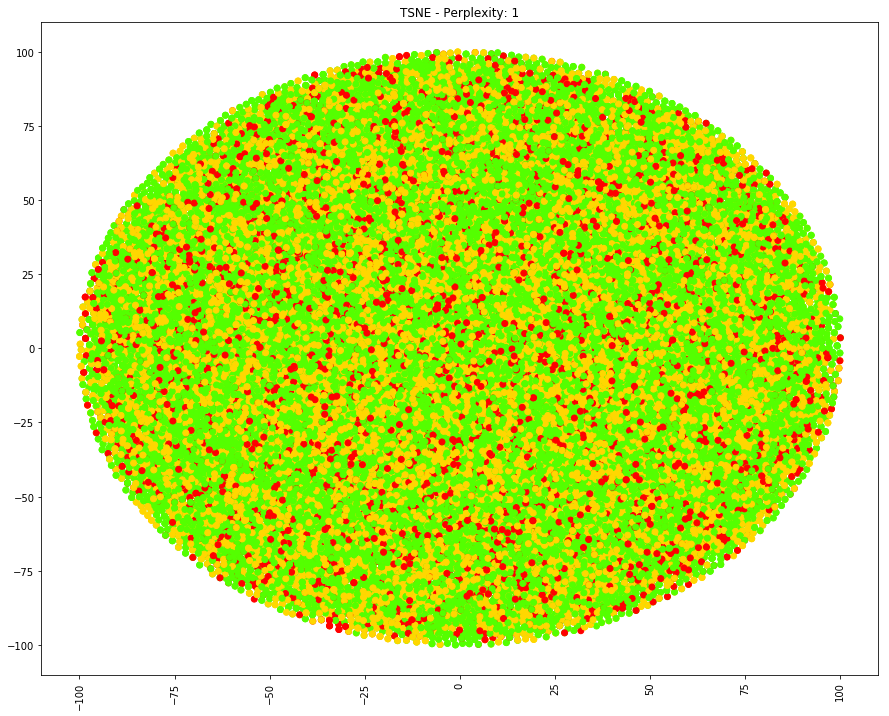

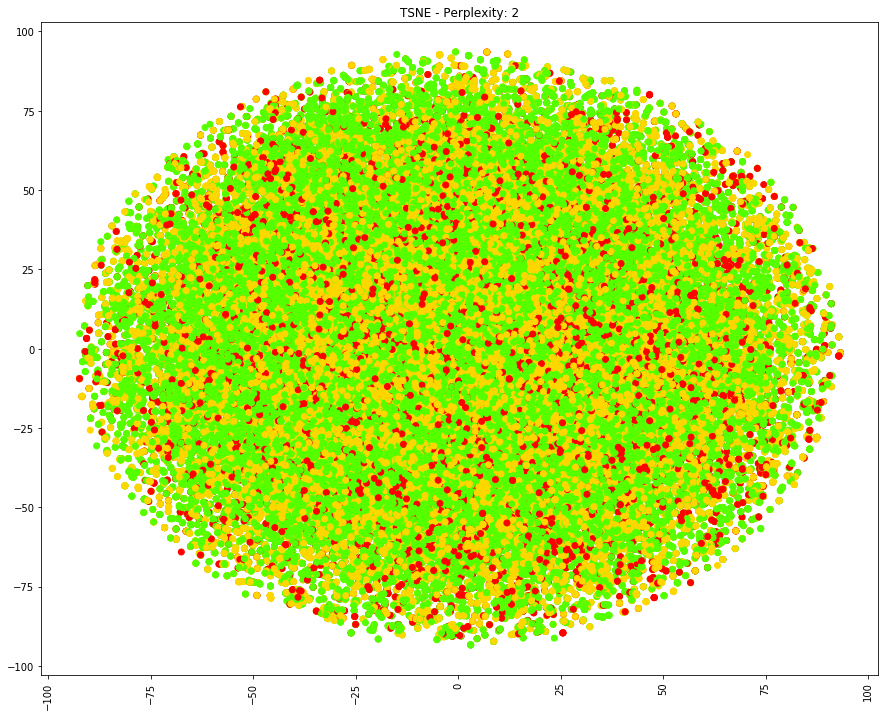

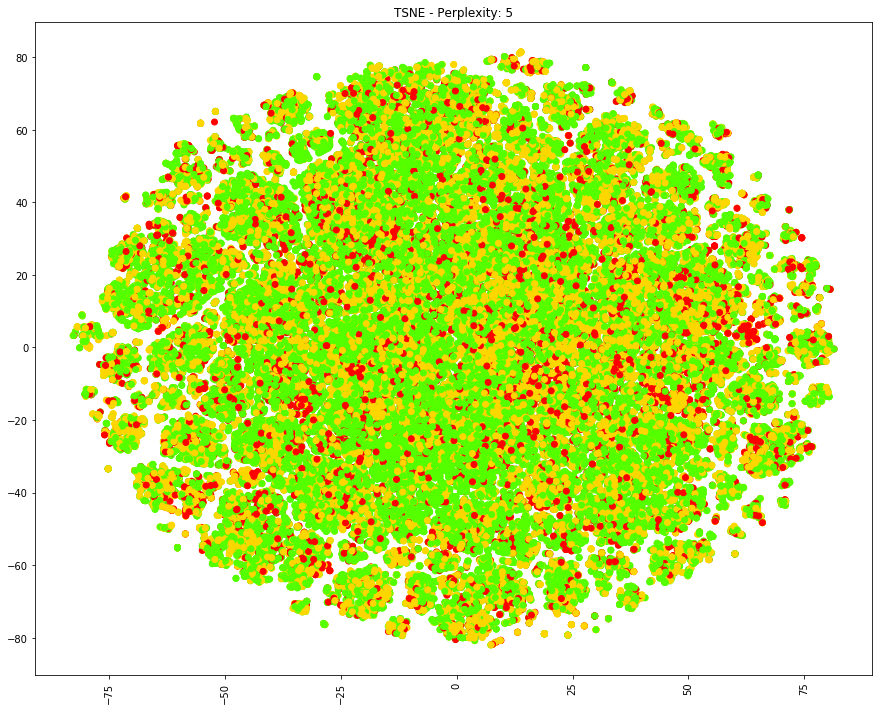

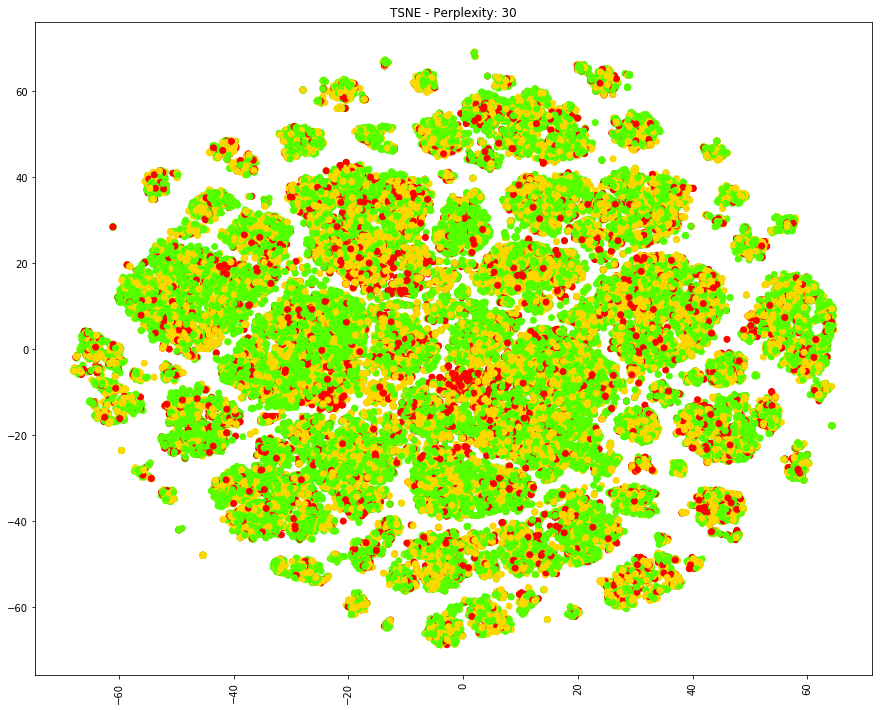

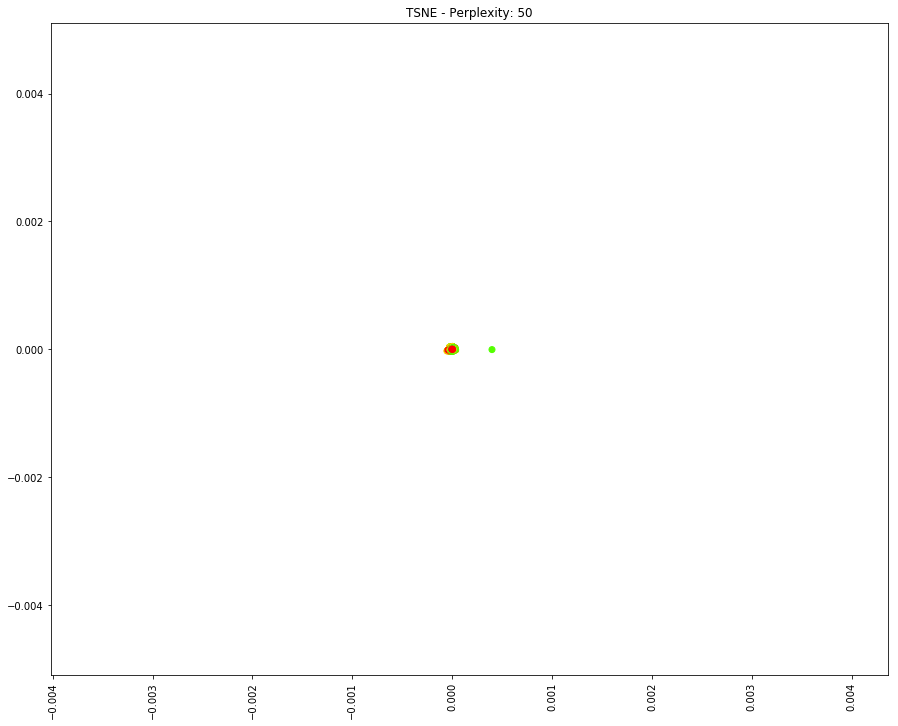

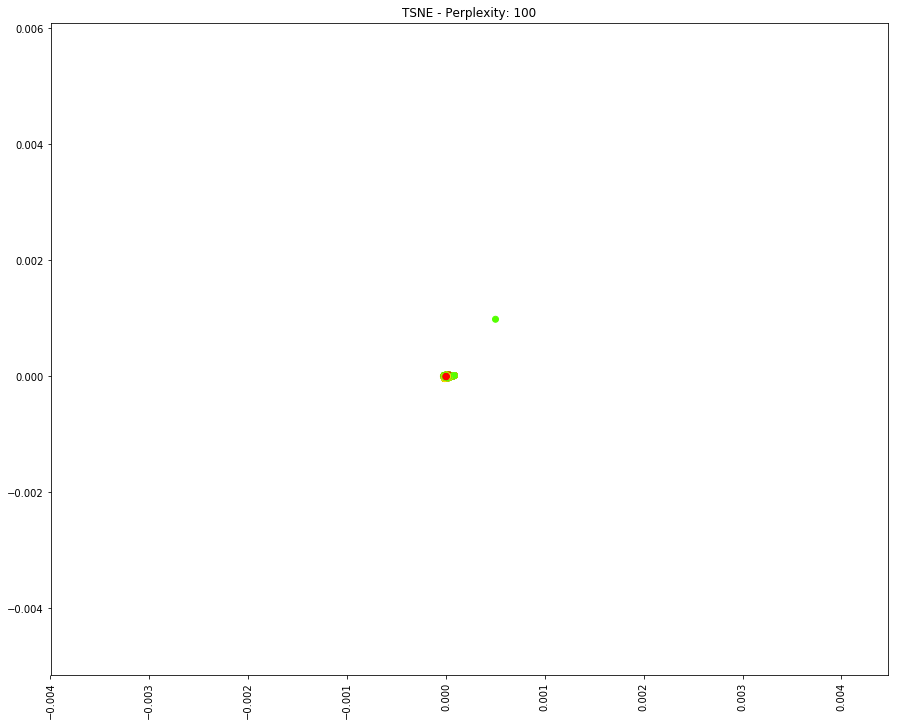

CPU times: user 1d 13h 47min 31s, sys: 6min 8s, total: 1d 13h 53min 39s
Wall time: 9h 12min 23s


In [30]:
%%time
##############################
# Clustering: 
#        tSNE
##############################

# iterate on perplexity
perplexity = [1, 2, 5, 30, 50, 100]

# apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for p in perplexity:
    # apply tSNE
    tsne = TSNE(n_components=2, perplexity=p, n_iter=5000, learning_rate=10)
    tsne_transformed = tsne.fit_transform(X_scaled)

    # display results from tSNE
    plt.subplots(figsize=(15, 12))
    plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=Y, cmap='prism', alpha=1)
    plt.xticks(rotation=90)
    plt.title("TSNE - Perplexity: {}".format(tsne.get_params()['perplexity']))
    plt.show()


# Miscellaneous